In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LinearRegression

from classes.data_handler import DataHandler, Filter

pd.set_option('display.max_columns', None)

#1 recupération des données

#2 analyse des données

3 nettoyage des données

4 choix du type d'entrainement

5 choix du nmodele

### **1. Récupération des données** 

On extrait les données pertinentes du dataset

In [2]:
def extract_data(cities: list[str], types_local: list[str]) -> None:
    for city in cities:
        for type_local in types_local:
            filters = [
                Filter('Commune', '==', city),
                Filter('Type local', '==', type_local),
                Filter('Nature mutation', '==', 'vente'),
                Filter('Valeur fonciere', 'notnull', None),
                Filter('Surface reelle bati', 'notnull', None),
                Filter('Nombre pieces principales', '==', 4),
            ]

            df = DataHandler.extract_data("data/ValeursFoncieres-2022.txt", filters)
            df = df[["Surface reelle bati", "Nombre pieces principales", "Type local", "Surface terrain", "Nombre de lots", "Valeur fonciere"]]
            df = DataHandler.add_data(df)
            df = DataHandler.clean_data(df)
            DataHandler.persist_data(df, f"data/{city}_{type_local}.csv")

extract_data(["lille"], ["appartement", "maison"])

Data extracted
Data converted
Data cleaned
Data persisted to data/lille_appartement.csv
Data extracted
Data converted
Data cleaned
Data persisted to data/lille_maison.csv


### **2. Analyse des données** 

On observe les données pour déterminer les colonnes à exploiter, traiter les aberrations éventuelles, etc..
On affiche d'abord un tableau descriptif de chaque colonne :

In [7]:
df = pd.read_csv("data/lille_maison.csv", sep=',', low_memory=False)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Surface reelle bati,340.0,83.935294,19.495599,44.000000,70.750000,80.000000,95.000000,165.000000
Nombre pieces principales,340.0,4.000000,0.000000,4.000000,4.000000,4.000000,4.000000,4.000000
Surface terrain,340.0,142.638235,84.800103,31.000000,84.750000,127.000000,175.250000,607.000000
Nombre de lots,340.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
prix_m2,340.0,3023.418163,1110.443128,487.607292,2368.448359,2874.400338,3483.790241,9192.073171


Observons les valeurs extrêmes

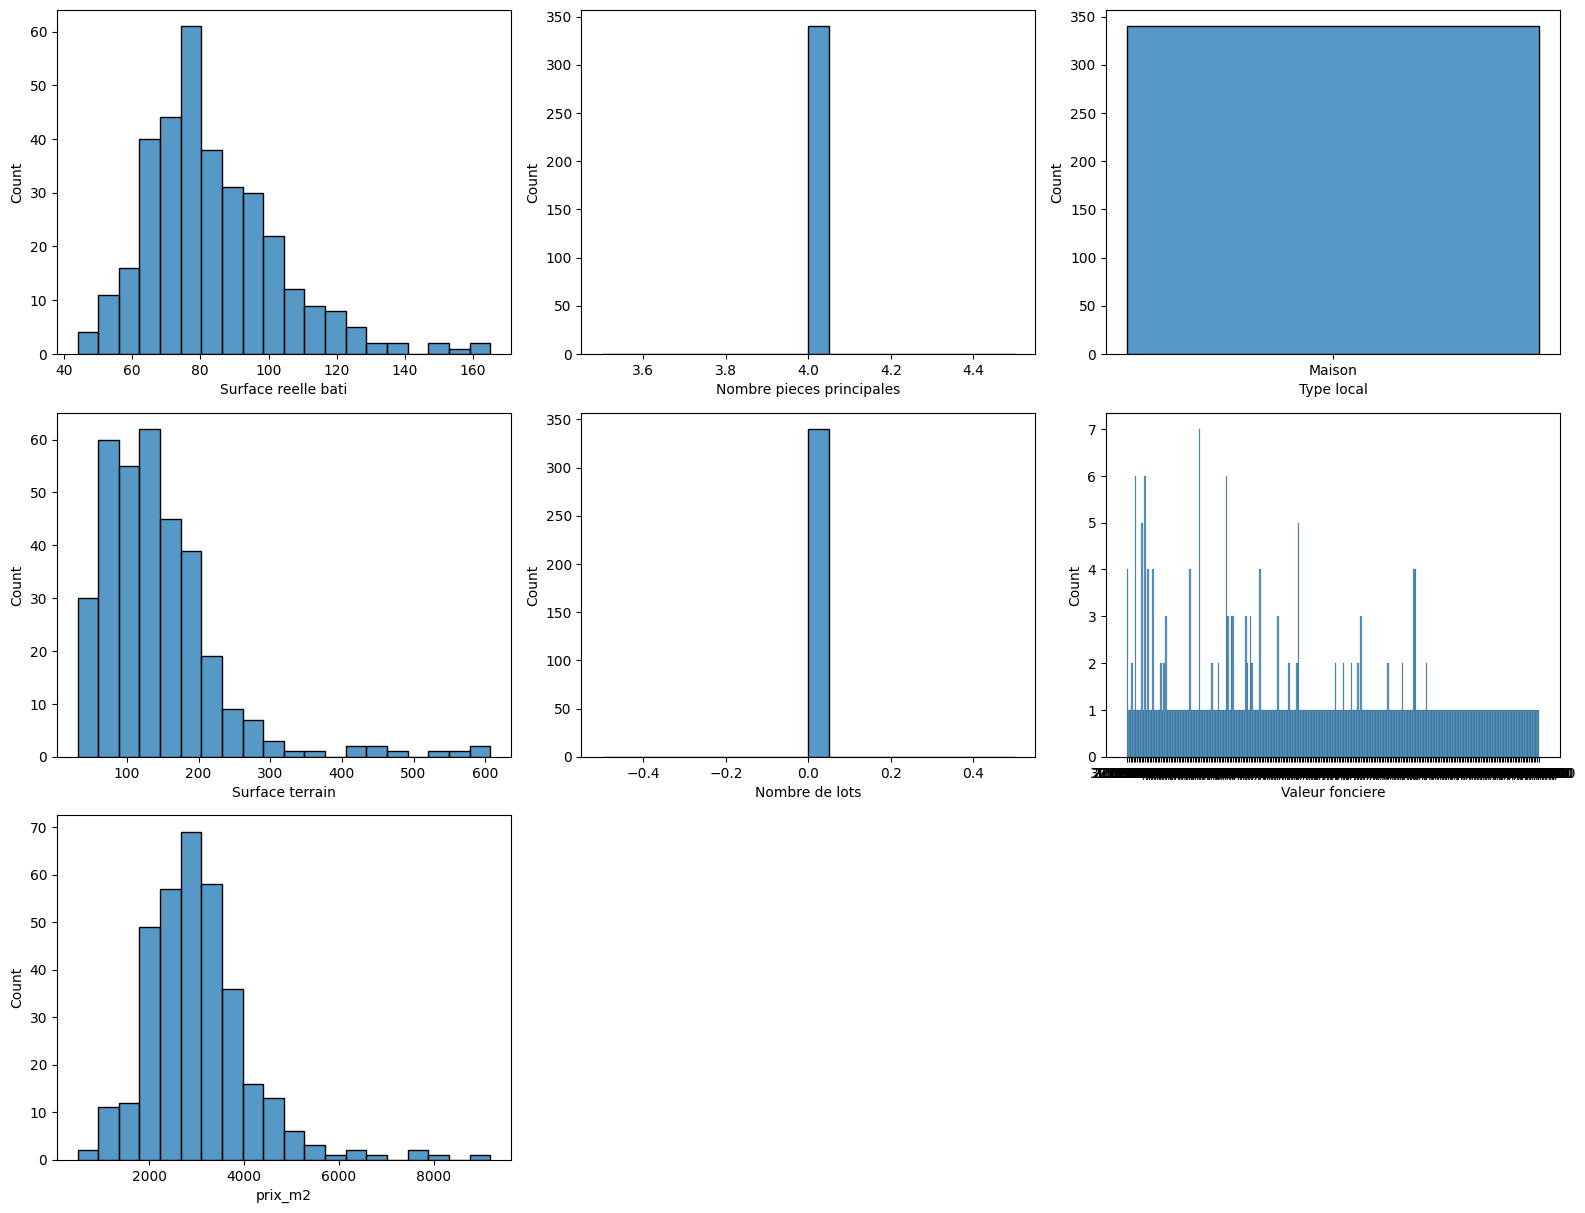

In [ ]:
cols = df.columns

plt.figure(figsize=(16,40))
for i, col in enumerate(cols, 1):
    plt.subplot(10, 3, i)
    sns.histplot(df[col], bins=20)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

On va chercher et supprimer les valeurs aberrantes (outliers)

In [ ]:
def get_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (df[column] < lower_bound) | (df[column] > upper_bound)

outliers = get_outliers(df, 'prix_m2')

df = df[~outliers].copy()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,prix_m2
count,325.000000,325.0,325.000000,325.0,325.000000
mean,84.021538,4.0,143.864615,0.0,2884.990026
std,19.515493,0.0,85.627063,0.0,829.528608
min,44.000000,4.0,31.000000,0.0,825.123273
25%,71.000000,4.0,87.000000,0.0,2333.333333
50%,80.000000,4.0,128.000000,0.0,2825.581395
75%,95.000000,4.0,176.000000,0.0,3372.590361
max,165.000000,4.0,607.000000,0.0,4918.918919


On peut désormais préparer les données pour l'entraînement

In [ ]:
def train_model(i:int, model): 
    X = df[["surface reelle bati", "surface terrain"]].values
    y = df["prix_m2"].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    
    return X_train, y_test, y_pred, model, scaler

X_train, y_test, y_pred, model_linear, scaler_linear = train_model(78, LinearRegression(solver="liblinear", class_weight="balanced"))

KeyError: "None of [Index(['surface reelle bati', 'surface terrain'], dtype='object')] are in the [columns]"